In [149]:
import gensim.models
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import scipy.stats as stats
import shutil

from zipfile import ZipFile
from gensim.models import KeyedVectors

- clean this bs (do it from scratch and do functions)
- add UNIQUE word num
- add repetitions number
- fix pause - word relation, as now we omit words we don't know and suddenly nothing works ++ omitting immediate repetitions from EVERYTHING

## let us get the data

In [150]:
def get_patients_data(path_to_csv, columns=None, dropna=True):
    """
    gets a csv dataset into pandas keeping specified columns and dropping or keeping na's

    :param path_to_csv: str
    :param columns: list of str, columns to keep, None by default (keeps all)
    :param dropna: bool, whether to drop na's, True by default
    :return: pd.DataFrame
    """
    res = pd.read_csv(path_to_csv, index_col=0)
    if columns:
        columns = list(filter(lambda col: col in res, columns))
        if columns:
            res = res[columns]
    if dropna:
        res = res.dropna()
    return res

**let us turn ;-separated str into lists**

In [151]:
csv = "verbal_fluency_schizo.csv"
columns = ['ID', 'sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS', 'animals', 'raw']
animals = get_patients_data(csv, columns, dropna=False)
animals = animals[~pd.isnull(animals['animals'])]
animals['animals'] = animals['animals'].apply(lambda s: [x.strip() for x in s.strip().split(';')])
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,raw
ID,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",(0.5) зебра (0.0) лев (0.2) слон (0.0) носорог...
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",(0.5) кошка (0.0) собака (0.0) корова (0.0) ко...
S7,"1,00","2,00","39,00","16,00","9,00","28,00","60,00","12,00",NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",(0.0) обезьяна (2.2) собака (0.0) кошка (4.1) ...
S8,"1,00","2,00","22,00","11,00","9,00","58,00","89,00","44,00",NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",(0.0) крокодил (0.0) динозавр (0.0) змея (0.0)...
S9,"2,00","2,00","18,00","11,00","13,00","20,00","57,00",NaN,"21,00","[тигр, лев, мышь, тигр, кот, собака, терьер, м...",(0.0) тигр (0.7) лев (0.0) мышь (0.7) тигр (3....


In [152]:
def get_times(s):
    if type(s) == str:
        s = s.strip()
        s = re.sub('[а-я]+', ' ', s)
        s = s.replace('·', '')
        while '  ' in s:
            s = s.replace('  ', ' ')
        s = s.replace('(', ' ')
        s = s.replace(')', ' ')
        return [float(x) for x in s.split()]
    else:
        s

In [371]:
animals['raw'] = animals['raw'].apply(lambda s: s.strip() if type(s) == str else s)
animals['times'] = animals['raw'].apply(get_times)

In [373]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_words'] = animals['animals'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_times']
np.unique(animals[animals['len_times'] > 0]['diff'])

array([-1], dtype=int64)

**let us add dummy POS-tags for the model**

In [155]:
def add_POS_tags(patient_word_list):
    """
    adds "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param patient_word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(patient_word_list):
        if word:
            if ' ' in word:
                words = word.split()
                fisrts = words[:-1]
                fisrts = ' '.join([x + '_ADJ' for x in fisrts])
                second = words[-1] + '_NOUN'
                res.append(fisrts + ' ' + second)
            else:
                res.append(word+'_NOUN')
    return res

In [156]:
add_POS_tags(['жираф', 'морской свинка', 'большой мадагаскарский таракан'])

['жираф_NOUN',
 'морской_ADJ свинка_NOUN',
 'большой_ADJ мадагаскарский_ADJ таракан_NOUN']

In [157]:
animals['animals_POS'] = animals['animals'].apply(add_POS_tags)
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,raw,times,len_times,len_words,diff,animals_POS
ID,,,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",(0.5) зебра (0.0) лев (0.2) слон (0.0) носорог...,"[0.5, 0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.3, 2.0, ...",27,26,-1,"[зебра_NOUN, лев_NOUN, слон_NOUN, носорог_NOUN..."
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",(0.5) кошка (0.0) собака (0.0) корова (0.0) ко...,"[0.5, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.1, 0.0, ...",34,33,-1,"[кошка_NOUN, собака_NOUN, корова_NOUN, коза_NO..."
S7,"1,00","2,00","39,00","16,00","9,00","28,00","60,00","12,00",NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",(0.0) обезьяна (2.2) собака (0.0) кошка (4.1) ...,"[0.0, 2.2, 0.0, 4.1, 2.2, 22.5, 4.4, 2.0, 9.1,...",15,14,-1,"[обезьяна_NOUN, собака_NOUN, кошка_NOUN, порос..."
S8,"1,00","2,00","22,00","11,00","9,00","58,00","89,00","44,00",NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",(0.0) крокодил (0.0) динозавр (0.0) змея (0.0)...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.7, ...",20,19,-1,"[крокодил_NOUN, динозавр_NOUN, змея_NOUN, заяц..."
S9,"2,00","2,00","18,00","11,00","13,00","20,00","57,00",NaN,"21,00","[тигр, лев, мышь, тигр, кот, собака, терьер, м...",(0.0) тигр (0.7) лев (0.0) мышь (0.7) тигр (3....,"[0.0, 0.7, 0.0, 0.7, 3.7, 0.2, 1.3, 5.2, 6.4, ...",11,10,-1,"[тигр_NOUN, лев_NOUN, мышь_NOUN, тигр_NOUN, ко..."


## let us unzip the best model into a temporary directory and load it

In [161]:
model_zip_name = 'models/tayga_upos_skipgram_300_2_2019.zip'
with ZipFile(model_zip_name, 'r') as myzip:
    myzip.extractall('models/tmp')

In [162]:
model_path = 'models/tmp/model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [178]:
wv = KeyedVectors.load('models/187/model.model')

In [ ]:
shutil.rmtree('models/tmp/')

In [164]:
model['слон_NOUN']

array([ 0.08601318, -0.6828482 , -0.22675529, -0.22827153, -0.01361705,
        0.24698313, -0.04402011, -0.2475504 ,  0.07414407, -0.27594137,
        0.1739021 , -0.00158702,  0.01958552,  0.03729556,  0.5432982 ,
        0.0611247 ,  0.14772898,  0.02181707,  0.20535886, -0.11394621,
       -0.17934537,  0.2540597 ,  0.19710991, -0.06129597, -0.5700048 ,
        0.00850122,  0.2670366 ,  0.3233264 , -0.03196438, -0.18470246,
        0.38322222, -0.02588548,  0.28374165, -0.19383   , -0.08458902,
        0.4244925 , -0.15542516,  0.19162974, -0.06713919, -0.20103349,
        0.06785759,  0.05808949,  0.03733297,  0.07999419, -0.10370225,
        0.06420214, -0.11548744,  0.00239497, -0.2272254 , -0.19429892,
       -0.15440041, -0.34388942, -0.31899017,  0.14440675, -0.00867636,
        0.24022427, -0.21015681, -0.36691037,  0.08985427, -0.0185655 ,
       -0.16598868,  0.10741134,  0.14276543, -0.22300471, -0.11224405,
       -0.05493741,  0.48073494,  0.1417331 , -0.2366079 , -0.10

**let us define a way of handling n-grams**

In [165]:
def collocation_handler(model, word, collocation_function=None):
    """
    gets a vector of a word or a bigram using a function to combine two vectors in a colloctaion
    
    :param model: gensim.Word2Vec model
    :param word: str, word or bi-gram
    :param collocation_function: function to combine two word vectors, None by default (np.mean is used)
    :return word_vector: np.ndarray, word vector
    :return not_found: int, number of words that were absent in the model
    """
    not_found = 0
    if ' ' in word:
        if not collocation_function:
            collocation_function = lambda vecs: np.mean(vecs, axis=0)
        words = word.split()
        vecs = []
        not_found = 0
        for word in words:
            if word in model:
                vecs.append(model[word])
            else:
                not_found += 1
        if len(vecs) == 0:
            word_vector = None
        elif len(vecs) == 1:
            word_vector = vecs[0]
        else:
            word_vector = collocation_function(vecs)
    else:
        if word in model:
            word_vector = model[word]
        else:
            word_vector = None
            not_found = 1
    return word_vector, not_found

In [166]:
collocation_handler(model, 'морской_ADJ свинка_NOUN')

(array([-2.40569502e-01, -2.65819699e-01,  2.47903019e-02,  3.60203013e-02,
         2.68500924e-01,  3.60444307e-01, -1.26190349e-01,  2.53701117e-03,
        -3.17839533e-02,  1.25960782e-02,  1.35463476e-01, -1.68274075e-01,
        -1.90845385e-01,  7.88793340e-03, -9.61406678e-02, -1.11334942e-01,
         3.70166034e-01,  4.08405542e-01, -1.55779645e-01,  1.14374891e-01,
        -5.48553877e-02,  9.86299813e-02, -1.45992398e-01,  1.50981732e-02,
        -5.47238231e-01,  1.22930489e-01,  2.63999104e-01, -7.07200095e-02,
        -2.63602316e-01, -1.15159288e-01,  2.86967874e-01, -9.13257897e-03,
        -1.56521797e-02, -1.82685494e-01,  1.65465757e-01,  1.50530890e-01,
        -4.82448116e-02,  2.58174300e-01, -2.40019649e-01, -3.00360192e-02,
         1.40154660e-02, -1.70106724e-01, -8.29464346e-02, -1.76284164e-01,
         2.51417272e-02, -2.48923823e-01,  2.01466367e-01, -4.91439104e-01,
        -3.01076591e-01,  6.46086335e-02, -3.41826528e-02, -7.60434270e-02,
         2.8

In [167]:
collocation_handler(model, 'kiufuer')

(None, 1)

In [168]:
collocation_handler(model, 'kiufuer свинка_NOUN')

(array([-0.24443445, -0.5771195 , -0.13867165,  0.20017748,  0.3237785 ,
         0.2328046 , -0.34049097,  0.03349691,  0.12646833,  0.18448459,
         0.24623515, -0.12471765, -0.16479154, -0.07681715, -0.03212069,
        -0.08459495,  0.36097503,  0.38839626,  0.05949978,  0.05217168,
        -0.19348028,  0.09540386, -0.47699255, -0.12457881, -0.57800716,
         0.14449762,  0.3292182 ,  0.16089065, -0.32228065, -0.08594431,
         0.36661896, -0.03241307,  0.18824233, -0.22222158,  0.11502609,
         0.19788364,  0.01979579,  0.24609703, -0.21542795,  0.03033229,
         0.17665893,  0.07056163, -0.2209753 , -0.15497443, -0.08215433,
         0.0810919 ,  0.18020569, -0.45008856,  0.00310612, -0.07636507,
         0.19055578,  0.04309632,  0.04444195,  0.23624417, -0.43727016,
         0.24869345, -0.19005972, -0.06291488,  0.00923101, -0.08208547,
         0.0858584 ,  0.20341316, -0.181405  , -0.06822711,  0.05965808,
         0.12983981,  0.37337086,  0.48328945, -0.0

## let us compute cosine similarities of a list of words

In [169]:
oov_list = []

In [170]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [171]:
def get_cos_sim_list(model, patient_word_list, collocation_function=None, oov=True):
    """
    calculates pairwise cosine similarities of words or collocations in a word list

    cosine similarity for a word pair that has a collocation is calculated as
    cosine similarity between a word vector and an average of word vectors from the collocation

    :param model: gensim.word2vec model
    :param patient_word_list: list of strings, words produced by the patient
    :param collocation_function: function combining two word vectors in a collocation, optional default is mean
    :param oov: bool, optional (True by deafult), whether to add oov words to a global variable oov_list
    :return patient_cos_sim_list: list of float, pairwise cosine similarities
    :return not_found: int, number of words missing from the model vocabulary
    """
    patient_cos_sim_list = []
    not_found = 0
    for j, word in enumerate(patient_word_list):
        if j > 0:
            previous_word = patient_word_list[j - 1]
            word_vector, nf = collocation_handler(model, word, collocation_function)
            not_found += nf
            previous_word_vector, nf = collocation_handler(model, previous_word, collocation_function)
            not_found += nf
            if word_vector is None:
                if oov:
                    oov_list.append(word)
                else:
                    continue
            elif previous_word_vector is not None:
                patient_cos_sim_list.append(cos_sim(word_vector, previous_word_vector))
            else:
                continue
    not_found = math.ceil(not_found / 2)
    return patient_cos_sim_list, not_found

In [172]:
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'жираф_NOUN'], oov=False)

([0.39405695, 0.33655587, 0.24216779], 0)

In [173]:
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'kjgfeagf','жираф_NOUN'], oov=False)

([0.39405695, 0.33655587], 1)

In [174]:
cf = lambda vecs: vecs[0] + 2*vecs[1:]
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'жираф_NOUN'], collocation_function=cf, oov=False)

([array([0.27864033, 0.27864033], dtype=float32), 0.33655587, 0.24216779], 0)

**let us apply the technique to the dataset**

In [181]:
animals['cos_sim_list'], animals['oov_words'] = zip(*animals['animals_POS'].map(lambda x: get_cos_sim_list(model, x)))
animals['no_pos_cos_sim_list'], animals['no_pos_oov_words'] = zip(*animals['animals_POS'].map(lambda x: get_cos_sim_list(wv, x)))
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,times,len_times,len_words,diff,animals_POS,cos_sim_list,oov_words,mean_cos_sim,no_pos_cos_sim_list,no_pos_oov_words
ID,,,,,,,,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,"[0.5, 0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.3, 2.0, ...",27,26,-1,"[зебра_NOUN, лев_NOUN, слон_NOUN, носорог_NOUN...","[0.49467045, 0.6340528, 0.7822212, 0.6697994, ...",0,0.579143,"[0.25296235, 0.23456416, 0.31641218, 0.4103258...",0
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,"[0.5, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.1, 0.0, ...",34,33,-1,"[кошка_NOUN, собака_NOUN, корова_NOUN, коза_NO...","[0.7347066, 0.54376155, 0.80458444, 0.40768248...",3,0.572099,"[0.55340976, 0.2679423, 0.25755632, 0.09344128...",0
S7,"1,00","2,00","39,00","16,00","9,00","28,00","60,00","12,00",NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",...,"[0.0, 2.2, 0.0, 4.1, 2.2, 22.5, 4.4, 2.0, 9.1,...",15,14,-1,"[обезьяна_NOUN, собака_NOUN, кошка_NOUN, порос...","[0.4697804, 0.7347066, 0.4843274, 0.6263563, 0...",1,0.619142,"[0.29874402, 0.55340976, 0.26931575, 0.4277774...",0
S8,"1,00","2,00","22,00","11,00","9,00","58,00","89,00","44,00",NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.7, ...",20,19,-1,"[крокодил_NOUN, динозавр_NOUN, змея_NOUN, заяц...","[0.62539405, 0.3755675, 0.4221906, 0.67135924,...",0,0.533197,"[0.3542624, 0.11625, 0.26751152, 0.08533706, 0...",0
S9,"2,00","2,00","18,00","11,00","13,00","20,00","57,00",NaN,"21,00","[тигр, лев, мышь, тигр, кот, собака, терьер, м...",...,"[0.0, 0.7, 0.0, 0.7, 3.7, 0.2, 1.3, 5.2, 6.4, ...",11,10,-1,"[тигр_NOUN, лев_NOUN, мышь_NOUN, тигр_NOUN, ко...","[0.8116844, 0.3919313, 0.43978673, 0.5536955, ...",0,0.502556,"[0.37178648, 0.10433982, 0.3678957, 0.30158088...",0


In [385]:
len(animals.iloc[1].times)

32

In [384]:
len(animals.iloc[1].cos_sim_list)

29

In [378]:
animals['first_pause'] = animals['times'].apply(lambda l: l[0] if l else l)
animals['last_pause'] = animals['times'].apply(lambda l: l[-1] if l else l)
animals['total_pause'] = animals['times'].apply(lambda l: sum(l) if l else l)
animals['times'] = animals['times'].apply(lambda l: l[1:-1] if l else l)

In [379]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_sims'] = animals['cos_sim_list'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_sims']
animals[animals['len_times'] > 0]['diff']

ID
S5      1
S6      4
S7      1
S8      1
S9      1
S11     1
S12     3
S13     3
S14     1
S15     2
S16     1
S17     1
S19     3
S20     1
H1      1
H2      1
H3      2
H4      5
H5      5
H6      5
H7      1
H8      3
H9      3
H10     3
H11     1
H12     1
H13     2
H14     1
H15     1
H16     3
H17    12
H18     1
H19     1
H20     3
H21     5
Name: diff, dtype: int64

In [361]:
animals['time_sim'] = animals.apply(lambda row: stats.spearmanr(row['times'], row['cos_sim_list']) if row['times'] else np.nan, axis=1)

ValueError: ('all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 32 and the array at index 1 has size 29', 'occurred at index S6')

In [309]:
animals['mean_cos_sim'] = animals['cos_sim_list'].apply(np.mean)
animals['no_pos_mean_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.mean)
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5,binary_diagnosis,first_pause,last_pause,total_pause
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,"1,00",30.0,16.0,15.0,42.0,85.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,9,11,11,13,14,24,1,0.5,9.8,48.0
S6,1.0,"1,00",36.0,16.0,12.0,30.0,83.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,9,10,10,13,13,27,1,0.5,0.0,51.9
S7,1.0,"2,00",39.0,16.0,9.0,28.0,60.0,12.0,NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",...,6,6,6,7,8,12,1,0.0,0.0,57.9
S8,1.0,"2,00",22.0,11.0,9.0,58.0,89.0,44.0,NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",...,9,9,9,10,10,10,1,0.0,0.0,35.1
S9,2.0,"2,00",18.0,11.0,13.0,20.0,57.0,NaN,21.0,"[тигр, лев, мышь, тигр, кот, собака, терьер, м...",...,5,5,5,6,6,8,1,0.0,4.4,44.9


In [184]:
flatten = lambda l: [item for sublist in l for item in sublist]
list_cos_sim_all = flatten(animals['cos_sim_list'].tolist())
median = np.median(list_cos_sim_all)
p25 = np.percentile(list_cos_sim_all, 25)
p75 = np.percentile(list_cos_sim_all, 75)
mean = np.mean(list_cos_sim_all)
print(f'mean: {mean}\n\n25th percentile: {p25}\nmedian: {median}\n75th percentile: {p75}')

mean: 0.5526943802833557

25th percentile: 0.44750987738370895
median: 0.5475584268569946
75th percentile: 0.6697993874549866


In [185]:
no_pos_list_cos_sim_all = flatten(animals['no_pos_cos_sim_list'].tolist())
no_pos_median = np.median(no_pos_list_cos_sim_all)
no_pos_p25 = np.percentile(no_pos_list_cos_sim_all, 25)
no_pos_p75 = np.percentile(no_pos_list_cos_sim_all, 75)
no_pos_mean = np.mean(no_pos_list_cos_sim_all)
print(f'mean: {no_pos_mean}\n\n25th percentile: {no_pos_p25}\nmedian: {no_pos_median}\n75th percentile: {no_pos_p75}')

mean: 0.2717908024787903

25th percentile: 0.15656758472323418
median: 0.26794230937957764
75th percentile: 0.3705585151910782


In [294]:
animals['binary_diagnosis'] = animals['diagnosis'].apply(lambda x: 1 if x == '1,00' or x == '2,00' else 0)

In [310]:
to_corr = ['first_pause', 'last_pause', 'total_pause', 'len_words', 
           'mean_cos_sim', 'no_pos_mean_cos_sim', 
           'oov_words', 'no_pos_oov_words']

In [343]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x'):
    res = pd.DataFrame(columns=[stat_name, 'p', 'sig'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[target_column], df[column], nan_policy=nan_policy))
        res.loc[column] = [r, p, p<0.05]
    res = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig'], index=columns_to_test)
    return res.sort_values(['p']).style.background_gradient(axis=0, cmap='Reds')

In [344]:
display_test(animals, to_corr, 'binary_diagnosis', stats.ttest_ind, stat_name='t')

,t,p,sig
total_pause,-51.8916,1.22786e-81,True
len_words,-22.4407,1.40441e-51,True
mean_cos_sim,-8.63767,5.19631e-15,True
no_pos_oov_words,4.25844,3.47827e-05,True
last_pause,-3.75971,0.000269024,True
oov_words,-3.49934,0.000602411,True
no_pos_mean_cos_sim,-2.11208,0.036213,True
first_pause,-0.752814,0.4531,False


In [345]:
display_test(animals, to_corr, 'TD', stats.spearmanr, stat_name='r')

,r,p,sig
len_words,-0.601473,0.00010451,True
total_pause,0.451249,0.00651213,True
no_pos_mean_cos_sim,0.222158,0.192831,False
oov_words,-0.138045,0.422035,False
last_pause,0.129455,0.458586,False
first_pause,0.105715,0.545577,False
mean_cos_sim,0.0756028,0.661215,False
no_pos_oov_words,0,1,False


In [346]:
display_test(animals, to_corr, 'PANSS_1', stats.spearmanr, stat_name='r')

,r,p,sig
len_words,-0.636316,3.02763e-05,True
total_pause,0.483265,0.00327366,True
oov_words,-0.144129,0.401669,False
first_pause,0.138965,0.425947,False
last_pause,0.133981,0.442889,False
no_pos_mean_cos_sim,0.0520854,0.76289,False
mean_cos_sim,0.0406712,0.813811,False
no_pos_oov_words,0,1,False


In [347]:
display_test(animals, to_corr, 'PANSS_O', stats.spearmanr, stat_name='r')

,r,p,sig
len_words,-0.543826,0.000607748,True
total_pause,0.388397,0.0211278,True
no_pos_mean_cos_sim,0.11863,0.490761,False
oov_words,-0.0623106,0.718084,False
mean_cos_sim,0.0607978,0.724659,False
last_pause,0.0260502,0.881914,False
first_pause,0.0247318,0.887852,False
no_pos_oov_words,0,1,False


## clustering methods (Kim et al 2019)
[Automatic Scoring of Semantic Fluency](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6532534/) <br>
Best performance:
- English: threshold median
- Korean: threshold median, sharp


The models in the paper were selected w2v by median threshold correlation with manual counts _(questionable decision!)_
- English: the best model was the skip-gram model with d = 300,w = 4 (ρ = 0.657)
- Korean: the best model was the CBOW model with d = 1000,w = 4 (ρ = 0.572)


inter-group similarity would not work well on a small sample (as it relies on random negative sampling)

<img src="kim2019.jpg">

In [186]:
ex_list = animals['cos_sim_list'].tolist()[0]

### threshold cutoff
cluster boundary
- median & 25th percentile in the whole dataset
- average cosine similarity of each participant

In [188]:
def threshold_cutoff(list_of_values, threshold):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param threshold: int or float, value that elements must exceed
    :return ids: list of int, ids where value in list_of_values is below threshold
    :return cluster_num: int, number of values below threshold + 1
    """
    if type(list_of_values) != np.ndarray:
        list_of_values = np.array(list_of_values)
    ids = list(np.where(list_of_values < threshold)[0])
    cluster_num = len(ids) + 1
    return ids, cluster_num

In [189]:
p10 = np.percentile(ex_list, 10)
print(p10)
threshold_cutoff(ex_list, p10)

0.3803179025650024


([20, 22, 23], 4)

### sharp change
cluster boudary - cosine similarity is half _(or some other factor!)_ the average distance in the current cluster

In [190]:
def sharp_change(list_of_values, factor):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param factor: int or float, nonzero, sharpness of change
    :return ids: list of int, ids where value in list_of_values changes sharply 
                            (by a factor of factor param)
    :return cluster_num: int, number of sharp changes + 1
    """
    cluster = [list_of_values[0]]
    ids = []
    for i, value in enumerate(list_of_values):
        current_mean = np.mean(cluster)
        if value < current_mean/factor:
            ids.append(i)
            cluster = [value]
        else:
            cluster.append(value)
    cluster_num = len(ids) + 1
    return ids, cluster_num

In [191]:
ids, n = sharp_change(ex_list, 1.2)
print(ids)
print(np.array(ex_list)[ids], n)

[4, 8, 14, 20, 22]
[0.42707694 0.43308234 0.3803977  0.28599396 0.3802647 ] 6


**let us also define a function that divides a set of words into clusters by change-indicies**

In [192]:
def get_splits(some_list, *ids):
    """
    splits a list into sublists by ids
    
    :param wordlist: list to be split
    :param ids: *ids where splits should be
    :return: lsit of lists, ssplit bu ids
    """
    ids = (0,) + tuple(data+1 for data in ids) + (len(some_list)+1,)
    lists = []
    for start, end in zip(ids, ids[1:]):
        sub = some_list[start:end]
        if sub:
            lists.append(sub)
    return lists

In [193]:
get_splits(['1', '2', '3', '4', '5'], 0, 2)

[['1'], ['2', '3'], ['4', '5']]

In [194]:
get_splits(['1', '2', '3', '4', '5'], 1, 4)

[['1', '2'], ['3', '4', '5']]

In [195]:
def print_splitted(list_of_lists):
    """
    prints a list of lists splitting inner lists by , and outer by ||
    
    :param list_of_lists: list of lists
    """
    list_of_lists = [map(str, l) for l in list_of_lists]
    list_of_lists = [', '.join(l) for l in list_of_lists]
    print(' || '.join(list_of_lists))

In [196]:
print_splitted(get_splits([1, 2, 3, 4, 5], 1, 4))

1, 2 || 3, 4, 5


**let us try to split a real list and see the clusters**

In [197]:
print('sharp (factor=0.95)')
ex_animals = animals['animals'].tolist()[0]
ids, n = sharp_change(ex_list, 0.95)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('25th percentile')
p30 = np.percentile(ex_list, 25)
ids, n = threshold_cutoff(ex_list, p30)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('median')
ex_median = np.median(ex_list)
ids, n = threshold_cutoff(ex_list, ex_median)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('mean')
ex_mean = np.mean(ex_list)
ids, n = threshold_cutoff(ex_list, ex_mean)
print_splitted(get_splits(ex_animals, *ids))
print(n)

sharp (factor=0.95)
зебра || лев, слон, носорог || жираф || собака, кошка || медведь, жираф || коза, козел, баран, овца || бык, лошадь || зебра, лань, медведь, лиса, заяц, волк || павлин, павлин || змея || сокол, орел
11

25th percentile
зебра, лев, слон, носорог, жираф || собака, кошка, медведь, жираф, коза, козел, баран, овца, бык, лошадь || зебра || лань, медведь, лиса, заяц, волк || павлин, павлин || змея || сокол, орел
7

median
зебра || лев, слон, носорог, жираф || собака, кошка || медведь || жираф || коза, козел, баран, овца || бык, лошадь || зебра || лань || медведь, лиса, заяц, волк || павлин, павлин || змея || сокол, орел
13

mean
зебра || лев, слон, носорог, жираф || собака, кошка || медведь || жираф || коза, козел, баран, овца || бык, лошадь || зебра || лань || медведь, лиса, заяц, волк || павлин, павлин || змея || сокол, орел
13


### let us calculate number of clusters by these methods

In [200]:
animals['c_cut_median'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, median)[1])
animals['c_cut_mean'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, mean)[1])
animals['c_cut_p25'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[1])
animals['c_cut_mean_local'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['c_sharp_1.05'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['c_sharp_1.005'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['c_sharp_1.00001'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['c_sharp_0.95'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['c_sharp_0.8'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['c_sharp_0.5'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
ID,,,,,,,,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,9,9,4,15,9,11,11,13,14,24
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,17,18,7,19,9,10,10,13,13,27
S7,"1,00","2,00","39,00","16,00","9,00","28,00","60,00","12,00",NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",...,6,7,3,9,6,6,6,7,8,12
S8,"1,00","2,00","22,00","11,00","9,00","58,00","89,00","44,00",NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",...,13,13,10,12,9,9,9,10,10,10
S9,"2,00","2,00","18,00","11,00","13,00","20,00","57,00",NaN,"21,00","[тигр, лев, мышь, тигр, кот, собака, терьер, м...",...,5,5,3,5,5,5,5,6,6,8


In [199]:
animals['no_pos_c_cut_median'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_median)[1])
animals['no_pos_c_cut_mean'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_mean)[1])
animals['no_pos_c_cut_p25'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_p25)[1])
animals['no_pos_c_cut_mean_local'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['no_pos_c_sharp_1.05'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['no_pos_c_sharp_1.005'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['no_pos_c_sharp_1.00001'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['no_pos_c_sharp_0.95'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['no_pos_c_sharp_0.8'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['no_pos_c_sharp_0.5'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head()

,sex,diagnosis,age,education,TD,PANSS_O,PANSS_1,HDRS,Y2RS,animals,...,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
ID,,,,,,,,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","42,00","85,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",...,9,9,4,15,9,11,11,13,14,24
S6,"1,00","1,00","36,00","16,00","12,00","30,00","83,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",...,17,18,7,19,9,10,10,13,13,27
S7,"1,00","2,00","39,00","16,00","9,00","28,00","60,00","12,00",NaN,"[обезьяна, собака, кошка, поросенок, корова, х...",...,6,7,3,9,6,6,6,7,8,12
S8,"1,00","2,00","22,00","11,00","9,00","58,00","89,00","44,00",NaN,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",...,13,13,10,12,9,9,9,10,10,10
S9,"2,00","2,00","18,00","11,00","13,00","20,00","57,00",NaN,"21,00","[тигр, лев, мышь, тигр, кот, собака, терьер, м...",...,5,5,3,5,5,5,5,6,6,8


## let us see if there are correlations with the diagnosis

### let us check the normality

In [275]:
methods = ['c_cut_median', 'c_cut_mean', 'c_cut_p25', 'c_cut_mean_local', 
           'c_sharp_1.05', 'c_sharp_1.005', 'c_sharp_1.00001', 
           'c_sharp_0.95', 'c_sharp_0.8', 'c_sharp_0.5']
no_pos_methods = ['no_pos_' + el for el in methods]
animals.groupby(['binary_diagnosis'])[methods].apply(np.mean)

,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,10.417910,10.597015,5.567164,10.701493,6.925373,7.80597,7.940299,10.149254,14.328358,19.328358
1,10.266667,10.533333,6.266667,10.066667,6.266667,7.20000,7.200000,8.866667,12.333333,17.866667


In [276]:
animals.groupby(['binary_diagnosis'])[methods].apply(np.std)

,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,4.841208,4.905251,3.373398,3.947472,2.943819,3.125432,3.156990,3.533438,5.224478,7.191180
1,3.855155,3.862066,2.619584,3.415000,2.322834,2.712932,2.712932,2.801587,4.346135,6.427718


In [292]:
for d in [0, 1]:
    print(d)
    print(animals[animals['binary_diagnosis'] == d][methods].apply(lambda l: stats.normaltest(l, nan_policy='omit').pvalue))

0
c_cut_median        0.278722
c_cut_mean          0.496193
c_cut_p25           0.020023
c_cut_mean_local    0.834424
c_sharp_1.05        0.351627
c_sharp_1.005       0.913821
c_sharp_1.00001     0.913960
c_sharp_0.95        0.220239
c_sharp_0.8         0.806538
c_sharp_0.5         0.837643
dtype: float64
1
c_cut_median        0.470755
c_cut_mean          0.438010
c_cut_p25           0.297151
c_cut_mean_local    0.480014
c_sharp_1.05        0.271808
c_sharp_1.005       0.518295
c_sharp_1.00001     0.518295
c_sharp_0.95        0.826841
c_sharp_0.8         0.446367
c_sharp_0.5         0.873012
dtype: float64


In [288]:
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.mean)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,10.716418,10.970149,5.970149,11.343284,7.880597,8.313433,8.358209,10.044776,11.746269,16.134328
1,10.600000,10.866667,5.533333,11.466667,7.400000,7.866667,7.866667,9.000000,10.000000,14.266667


In [287]:
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.std)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,5.185531,5.171593,3.204335,4.440493,3.374719,3.473606,3.445531,3.453023,4.334324,6.310133
1,3.979950,4.096611,2.552559,4.014418,2.215100,2.604270,2.604270,3.119829,3.741657,6.212532


In [293]:
for d in [0, 1]:
    print(d)
    print(animals[animals['binary_diagnosis'] == d][no_pos_methods].apply(lambda l: stats.normaltest(l, nan_policy='omit').pvalue))

0
no_pos_c_cut_median        0.201822
no_pos_c_cut_mean          0.141694
no_pos_c_cut_p25           0.126208
no_pos_c_cut_mean_local    0.011114
no_pos_c_sharp_1.05        0.448044
no_pos_c_sharp_1.005       0.619646
no_pos_c_sharp_1.00001     0.629115
no_pos_c_sharp_0.95        0.440428
no_pos_c_sharp_0.8         0.132830
no_pos_c_sharp_0.5         0.855853
dtype: float64
1
no_pos_c_cut_median        0.170847
no_pos_c_cut_mean          0.251049
no_pos_c_cut_p25           0.390556
no_pos_c_cut_mean_local    0.658172
no_pos_c_sharp_1.05        0.292830
no_pos_c_sharp_1.005       0.500368
no_pos_c_sharp_1.00001     0.500368
no_pos_c_sharp_0.95        0.384772
no_pos_c_sharp_0.8         0.596612
no_pos_c_sharp_0.5         0.850287
dtype: float64


In [355]:
display_test(animals, methods, 'binary_diagnosis', stats.ttest_ind, stat_name='r')

,r,p,sig
c_sharp_0.95,-25.2496,4.84728e-58,True
c_cut_mean_local,-24.1128,1.77652e-55,True
c_sharp_0.8,-24.0918,1.98396e-55,True
c_sharp_0.5,-23.9609,3.95804e-55,True
c_sharp_1.00001,-22.0014,1.57361e-50,True
c_sharp_1.005,-21.8985,2.78073e-50,True
c_sharp_1.05,-20.7089,2.21607e-47,True
c_cut_mean,-19.7204,6.53597e-45,True
c_cut_median,-19.5763,1.51246e-44,True
c_cut_p25,-15.1126,9.34244e-33,True


In [357]:
display_test(animals, methods, 'PANSS_1', stats.spearmanr, stat_name='t')

,t,p,sig
c_sharp_0.95,-0.662184,1.08845e-05,True
c_sharp_0.8,-0.614368,6.72152e-05,True
c_sharp_0.5,-0.607527,8.51532e-05,True
c_cut_mean_local,-0.605831,9.02209e-05,True
c_sharp_1.00001,-0.586607,0.000169887,True
c_cut_median,-0.574904,0.000245016,True
c_sharp_1.005,-0.555646,0.000434731,True
c_cut_mean,-0.551986,0.000482895,True
c_sharp_1.05,-0.415614,0.0117064,True
c_cut_p25,-0.385401,0.0202717,True


In [348]:
display_test(animals, methods, 'PANSS_O', stats.spearmanr, stat_name='r')

,r,p,sig
c_sharp_0.95,-0.549133,0.000523671,True
c_sharp_0.5,-0.52518,0.00100613,True
c_sharp_0.8,-0.5243,0.00102964,True
c_cut_mean_local,-0.49448,0.00217299,True
c_sharp_1.00001,-0.480318,0.00302841,True
c_cut_median,-0.462417,0.0045184,True
c_sharp_1.005,-0.445174,0.00651499,True
c_cut_mean,-0.433762,0.00821815,True
c_sharp_1.05,-0.322665,0.0549392,False
c_cut_p25,-0.293888,0.081903,False


In [350]:
display_test(animals, methods, 'TD', stats.spearmanr, stat_name='r')

,r,p,sig
c_cut_mean_local,-0.604414,9.46593e-05,True
c_sharp_0.95,-0.595983,0.000125398,True
c_sharp_0.5,-0.586878,0.000168423,True
c_cut_median,-0.580364,0.000206893,True
c_cut_mean,-0.560087,0.000382065,True
c_sharp_1.00001,-0.549973,0.000511363,True
c_sharp_1.005,-0.52063,0.00113295,True
c_sharp_0.8,-0.50631,0.00162879,True
c_cut_p25,-0.401519,0.0152153,True
c_sharp_1.05,-0.313873,0.0622939,False


In [356]:
display_test(animals, no_pos_methods, 'binary_diagnosis', stats.ttest_ind, stat_name='t')

,t,p,sig
no_pos_c_sharp_0.95,-25.2994,3.75589e-58,True
no_pos_c_sharp_0.8,-23.5172,4.17453e-54,True
no_pos_c_cut_mean_local,-22.9629,8.20135e-53,True
no_pos_c_sharp_0.5,-22.1398,7.32791e-51,True
no_pos_c_sharp_1.00001,-21.8156,4.40373e-50,True
no_pos_c_sharp_1.005,-21.5696,1.73187e-49,True
no_pos_c_sharp_1.05,-21.2505,1.03542e-48,True
no_pos_c_cut_mean,-19.3543,5.5343e-44,True
no_pos_c_cut_median,-18.9144,7.36966e-43,True
no_pos_c_cut_p25,-16.4423,2.31682e-36,True


In [358]:
display_test(animals, no_pos_methods, 'PANSS_1', stats.spearmanr, stat_name='r')

,r,p,sig
no_pos_c_sharp_0.8,-0.624019,4.76872e-05,True
no_pos_c_sharp_0.5,-0.586825,0.000168709,True
no_pos_c_cut_median,-0.586238,0.000171895,True
no_pos_c_sharp_1.05,-0.576689,0.00023191,True
no_pos_c_cut_mean,-0.569423,0.000289493,True
no_pos_c_sharp_0.95,-0.55055,0.000503048,True
no_pos_c_sharp_1.005,-0.514519,0.00132534,True
no_pos_c_sharp_1.00001,-0.514519,0.00132534,True
no_pos_c_cut_mean_local,-0.506478,0.001622,True
no_pos_c_cut_p25,-0.49196,0.00230757,True


In [359]:
display_test(animals, no_pos_methods, 'PANSS_O', stats.spearmanr, stat_name='r')

,r,p,sig
no_pos_c_cut_median,-0.524676,0.00101955,True
no_pos_c_sharp_0.8,-0.511487,0.00143104,True
no_pos_c_cut_mean,-0.506435,0.00162374,True
no_pos_c_sharp_0.5,-0.504622,0.00169822,True
no_pos_c_sharp_1.05,-0.469933,0.0038295,True
no_pos_c_cut_p25,-0.466234,0.0041562,True
no_pos_c_sharp_0.95,-0.448235,0.00611349,True
no_pos_c_cut_mean_local,-0.416627,0.011483,True
no_pos_c_sharp_1.005,-0.406703,0.013834,True
no_pos_c_sharp_1.00001,-0.406703,0.013834,True


In [360]:
display_test(animals, no_pos_methods, 'TD', stats.spearmanr, stat_name='r')

,r,p,sig
no_pos_c_cut_median,-0.657009,1.34603e-05,True
no_pos_c_cut_mean,-0.636656,2.98903e-05,True
no_pos_c_cut_p25,-0.615586,6.44043e-05,True
no_pos_c_sharp_0.8,-0.525999,0.000984713,True
no_pos_c_sharp_1.05,-0.505171,0.00167535,True
no_pos_c_sharp_0.5,-0.503958,0.00172628,True
no_pos_c_cut_mean_local,-0.461653,0.00459404,True
no_pos_c_sharp_0.95,-0.448137,0.00612601,True
no_pos_c_sharp_1.005,-0.411178,0.0127279,True
no_pos_c_sharp_1.00001,-0.411178,0.0127279,True


## let us compare different separation methods to manual tagging

In [37]:
def splits_to_ids(list_of_lists):
    """
    gets ids of elements after which the splits are made
    
    :param list_of_lists: list of lists
    :return: list of int, ids of splits
    """
    out = []
    if len(list_of_lists) == 1:  # if no splits, as only one inner list
        return out
    else:
        current = 0
        for i, l in enumerate(list_of_lists):
            length = len(l)
            new_split_id = current + length - 1
            out.append(new_split_id)
            current = new_split_id + 1
        return out[:-1]

let us check, that it works correctly

In [38]:
ex_animals = animals['animals'].tolist()[0]
ids, n = sharp_change(ex_list, 1.005)
print(ids)
print(splits_to_ids(get_splits(ex_animals, *ids)))

[3, 5, 12, 14, 15, 16, 19]
[3, 5, 12, 14, 15, 16, 19]


**first, let us get out the manual tagging**

(Причесания разметчика:
Есть случаи, когда они переходят по ассоциации, так что слова относятся к разным кластерам, но связаны. Например утка-лебедь-рак-щука. Я размечала это как один кластер.)

In [39]:
with open('clustered.txt', 'r', encoding='utf-8') as f:
    lines = [l.strip() for l in f.readlines()]
    lines = [l for l in lines if l and not l.startswith('36')]  # 36 - пустая строка

lines[0]

'1 слон; заяц, волк, олень; кенгуру, жираф; суслик, хомячок, кролик; пингвин, страус; носорог, крокодил; бурый медведь, белый медведь, панда, гризли; уж, еж; колобок; удав; фазан; козел'

**let us drop out of vocabulary words** <br>
let us strip them of POS-tags

In [40]:
oov_list

['альпака_NOUN',
 'трубкозуб_NOUN',
 'фламинго_NOUN',
 'вомбат_NOUN',
 'россомаха_NOUN',
 'собака-динго_NOUN']

In [41]:
def remove_POS_tags(word_list):
    """
    removes "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(word_list):
        if word:
            if ' ' in word:
                first, second = word.split()
                first = first.split('_')[0]
                second = second.split('_')[0]
                res.append(first + ' ' + second)
            else:
                res.append(word.split('_')[0])
    return res

In [42]:
oov_list = remove_POS_tags(oov_list)
oov_list

['альпака', 'трубкозуб', 'фламинго', 'вомбат', 'россомаха', 'собака-динго']

In [43]:
lines = [l.split(' ', 1) for l in lines]   # separate ids
lines = [[int(l[0]), l[1].split(';')] for l in lines]  # split clusters (by ;)
lines = [[l[0], [c.split(',') for c in l[1]]] for l in lines]  # split inside clusters (by ,)\
lines = [[l[0], [[w.strip() for w in c if w not in oov_list] for c in l[1]]] for l in lines]  # strip words and remove oov words
correct_ids = dict([(l[0], splits_to_ids(l[1])) for l in lines])
lines = dict([tuple(el) for el in lines])
lines[1]

[['слон'],
 ['заяц', 'волк', 'олень'],
 ['кенгуру', 'жираф'],
 ['суслик', 'хомячок', 'кролик'],
 ['пингвин', 'страус'],
 ['носорог', 'крокодил'],
 ['бурый медведь', 'белый медведь', 'панда', 'гризли'],
 ['уж', 'еж'],
 ['колобок'],
 ['удав'],
 ['фазан'],
 ['козел']]

In [44]:
correct_ids[1]

[0, 3, 5, 8, 10, 12, 16, 18, 19, 20, 21]

let us add correct numbers of splits to animals dataframe

In [46]:
animals['correct_c_num'] = pd.Series(correct_ids).apply(len)
animals.head()

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,correct_c_num
ID,,,,,,,,,,,,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028,13,13,7,11,7,8,9,10,19,22,11
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_...","[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...",0,0.596951,7,8,5,8,6,8,8,9,11,17,6
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_...","[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...",1,0.609784,4,4,1,6,3,4,4,5,7,8,4
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU...","[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...",0,0.501028,14,14,11,12,9,10,10,11,11,19,10
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN...","[0.73176044, 0.653271, 0.73672754, 0.43279937,...",0,0.567047,8,8,3,8,5,6,6,7,10,12,6


In [47]:
model_name = 'tayga_upos_skipgram_300_2_2019'
out = animals.drop(columns = ['animals', 'animals_POS', 'cos_sim_list'])
out.to_csv(model_name + '.csv', index = False)

### let us compare absolut number of splits

In [48]:
split_nums_df = animals.drop(columns = ['animals', 'animals_POS', 'cos_sim_list', 'oov_words', 'mean_cos_sim'])

**let us see average cluster numbres for each method**

In [49]:
split_nums_df.apply(np.mean)

c_cut_median         9.086957
c_cut_mean           9.260870
c_cut_p25            5.043478
c_cut_mean_local     9.173913
c_sharp_1.05         6.173913
c_sharp_1.005        6.913043
c_sharp_1.00001      7.043478
c_sharp_0.95         9.086957
c_sharp_0.8         12.586957
c_sharp_0.5         16.630435
correct_c_num        9.956522
dtype: float64

**let us chect the normality**

In [50]:
split_nums_df.apply(lambda l: stats.normaltest(l)[1])

c_cut_median        0.614469
c_cut_mean          0.430152
c_cut_p25           0.085242
c_cut_mean_local    0.100790
c_sharp_1.05        0.608577
c_sharp_1.005       0.204767
c_sharp_1.00001     0.165279
c_sharp_0.95        0.213181
c_sharp_0.8         0.090579
c_sharp_0.5         0.048409
correct_c_num       0.009746
dtype: float64

### let us compare split positioning

In [53]:
clustering = animals[['cos_sim_list']].copy()
clustering['correct_cut'] = pd.Series(correct_ids)
clustering['c_cut_median'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, median)[0])
clustering['c_cut_mean'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, mean)[0])
clustering['c_cut_p25'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[0])
clustering['c_cut_mean_local'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[0])
clustering['c_sharp_1.05'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[0])
clustering['c_sharp_1.00001'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 1.00005)[0])
clustering['c_sharp_0.95'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[0])
clustering['c_sharp_0.8'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[0])
clustering['c_sharp_0.5'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[0])
clustering['possible_splits'] = clustering['cos_sim_list'].apply(lambda l: len(l))
clustering.head()

,cos_sim_list,correct_cut,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,possible_splits
ID,,,,,,,,,,,,
1,"[0.5170071, 0.67135924, 0.6578043, 0.56862366,...","[0, 3, 5, 8, 10, 12, 16, 18, 19, 20, 21]","[0, 5, 8, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[0, 5, 8, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[15, 16, 17, 19, 20, 21]","[5, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[5, 12, 14, 15, 16, 19]","[3, 5, 8, 12, 14, 15, 16, 19]","[0, 3, 5, 8, 12, 14, 15, 16, 19]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",22
2,"[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...","[2, 6, 8, 12, 13, 14]","[1, 2, 9, 12, 14, 15]","[1, 2, 9, 12, 13, 14, 15]","[1, 2, 12, 14]","[1, 2, 9, 12, 13, 14, 15]","[1, 2, 9, 12, 14]","[1, 2, 6, 8, 9, 12, 14]","[0, 1, 2, 6, 8, 9, 12, 14]","[0, 1, 2, 6, 7, 8, 9, 12, 14, 15]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16
3,"[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...","[2, 5, 7, 8]","[1, 4, 5]","[1, 4, 5]",[],"[1, 2, 3, 4, 5]","[1, 5]","[1, 4, 5]","[0, 1, 4, 5]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5, 6]",7
4,"[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...","[2, 4, 7, 9, 11, 12, 15, 16, 18, 19]","[0, 1, 2, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[0, 1, 2, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[1, 4, 7, 9, 11, 12, 15, 16, 18, 19]","[1, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[1, 4, 7, 9, 11, 15, 16, 19]","[1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15,...",20
5,"[0.73176044, 0.653271, 0.73672754, 0.43279937,...","[2, 5, 6, 7, 8, 9]","[3, 4, 6, 7, 8, 9, 10]","[3, 4, 6, 7, 8, 9, 10]","[3, 8]","[3, 4, 6, 7, 8, 9, 10]","[1, 3, 6, 8]","[1, 3, 6, 7, 8]","[0, 1, 3, 6, 7, 8]","[0, 1, 2, 3, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",11


In [54]:
def get_metrics(correct_splits_list, predicted_splits_list, total_splits_num):
    """
    gets accuracy, precision, recall and f-measure of two lists of entries
    
    :param predicted_splits_list: list, correct members
    :param predicted_list: list, predicted members
    :param total_splits_num: int, maximum of possible splits
    :return a: float, accuracy
    :return p: float, precision
    :return r: float, recall
    :return f1: float, f1-measure
    """
    cor = set(correct_splits_list)
    pred = set(predicted_splits_list)
    tp = len(cor.intersection(pred))
    tn = total_splits_num - len(cor)
    fp = len(pred) - tp
    fn = len(cor) - tp
    a = (tp + tn) / total_splits_num
    if not pred:
        p = 0
    else:
        p = tp / len(pred)
    if not cor:
        r = 0
    else:
        r = tp / len(cor)
    if not p + r:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    return a, p, r, f1

In [55]:
get_metrics([0,1], range(10), 10)

(1.0, 0.2, 1.0, 0.33333333333333337)

In [56]:
id27 = clustering.loc[27]
get_metrics(id27['correct_cut'], id27['c_cut_mean_local'], id27['possible_splits'])

(0.48, 1.0, 0.48, 0.6486486486486487)

In [57]:
def get_average_metrics(df, correct_col, predicted_col, total_length_col):
    """
    calculates average accuracy, precision, recall and f1-measure for a df with lists of entries
    
    :param df: pandas DataFrame, to search in
    :param correct_col: str, column name with lists of correct entries
    :param predicted_col: str, column name with lists of predicted entries
    :param total_length_col: str, column name with ints (numbers of posssible entries)
    :return a: float, mean accuracy
    :return p: float, mean precision
    :return r: float, mean recall
    :return f1: float, mean f1-measure
    """
    m = []
    for i in clustering.index:
         m.append(get_metrics(clustering.loc[i][correct_col], 
                                   clustering.loc[i][predicted_col], 
                                   clustering.loc[i][total_length_col]))
    return np.mean(m, axis=0)

In [58]:
methods = list(clustering.drop(['correct_cut', 'possible_splits', 'cos_sim_list'], axis=1))

In [59]:
metrics_df = pd.DataFrame(index=methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])

In [60]:
for method in methods:
    metrics_df.loc[method] = get_average_metrics(clustering, 'correct_cut', method, 'possible_splits')
metrics_df

,accuracy,precision,recall,f1-measure
c_cut_median,0.764904,0.735506,0.650322,0.650895
c_cut_mean,0.773509,0.733427,0.661191,0.657087
c_cut_p25,0.595463,0.804822,0.360821,0.455518
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515


In [61]:
df = pd.DataFrame([list(metrics_df.loc[metric]) for metric in methods], index = methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure
c_cut_median,0.764904,0.735506,0.650322,0.650895
c_cut_mean,0.773509,0.733427,0.661191,0.657087
c_cut_p25,0.595463,0.804822,0.360821,0.455518
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515


as we can see, the best metrics for acpproximation of splits are:
- cutoff at the mean is the best at catching all correct values (but poor at not-catching incorrect splits - making too many splits)
- sharp chage metrics (1.5 to 0.95) are good at only catching correct values (but bad at identifying all splits - making too little splits)

as we care more about only identifying correct splits (precision), then on identifying all correct splits (recall), let us weight the f-measure

$${\displaystyle F_{\beta }=(1+\beta ^{2})\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\beta ^{2}\cdot \mathrm {precision} +\mathrm {recall} }}}$$

let us use $\beta = 0.5 $, ads the $F_{0.5}$ which puts more emphasis on precision than recall.

In [62]:
df['f-weighted'] = (1 + 0.25) * df['precision'] * df['recall'] / (0.25 * df['precision'] + df['recall'])
df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
c_cut_median,0.764904,0.735506,0.650322,0.650895,0.716729
c_cut_mean,0.773509,0.733427,0.661191,0.657087,0.717744
c_cut_p25,0.595463,0.804822,0.360821,0.455518,0.64587
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965,0.729971
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543,0.677481
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662,0.689635
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037,0.695978
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797,0.677281
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515,0.633448


now we see that for a more precision-oriented task, the best metrics (at least on this model) are:
- cutoff at the local mean
- sharp chage metrics (1.05 to 0.95) 
- cutoff at the mean

overall the metrics are good-ish (0.7 is not all that good), but tolerable

**the problems might be due to:**
- only one manual tagging (might be low inter-rater agreement, if we tried many)
- tagging non-semantic assosiations as one cluster (утка-лебедь-рак-щука)
- out of vocabulary issues
- lack of training for the specific purpose (poor representation of animal lexicon)

In [122]:
print('correct')
print_splitted(get_splits(animals['animals'].tolist()[0], *correct_ids[1]))
print('median')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_cut_median'].tolist()[0]))
print('local mean')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_cut_mean_local'].tolist()[0]))
print('sharp 0.8')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_sharp_0.8'].tolist()[0]))
print('sharp 1.00001')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_sharp_1.00001'].tolist()[0]))

correct
слон || заяц, волк, олень || кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус || носорог, крокодил || бурый медведь, белый медведь, панда, гризли || уж, еж || колобок || удав || фазан || козел
median
слон || заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
local mean
слон, заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик, пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
sharp 0.8
слон || заяц, волк || олень || кенгуру || жираф || суслик || хомячок || кролик || пингвин || страус || носорог || крокодил || бурый медведь, белый медведь || панда || гризли || уж, еж, колобок || удав || фазан || козел
sharp 1.00001
слон, заяц, волк, олень || кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус, носорог, крокодил || бурый 

## let us correlate the personal information with manual tagging

**let us see means and standard deviations**

In [213]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']:
    animals[col] = animals[col].apply(lambda s: float(s.replace(',', '.')) if type(s) == str else s)

In [216]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']].apply(np.nanmean)

age          34.474268
education    14.895062
TD            7.666667
PANSS_O      22.361111
PANSS_1      47.694444
HDRS         27.000000
Y2RS         18.000000
dtype: float64

In [218]:
animals['education'] = animals['education'].fillna(math.ceil(np.nanmean(animals['education'])))
animals['age'] = animals['age'].fillna(math.ceil(np.nanmean(animals['age'])))

In [220]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']].apply(np.std)

age          16.842849
education     2.502118
TD            3.894440
PANSS_O       9.484352
PANSS_1      21.400700
HDRS         13.140269
Y2RS          3.000000
dtype: float64

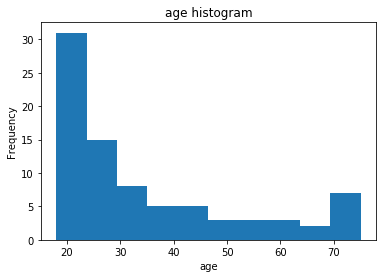

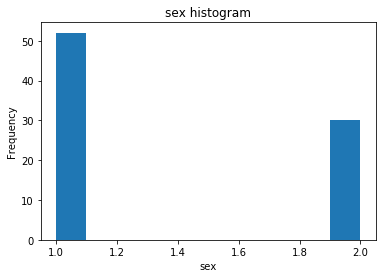

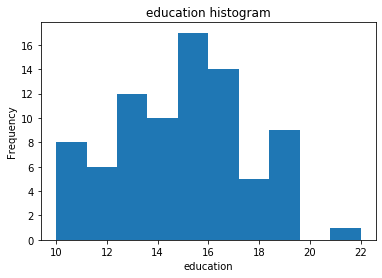

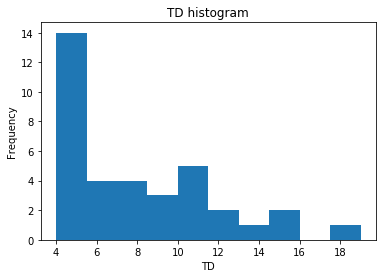

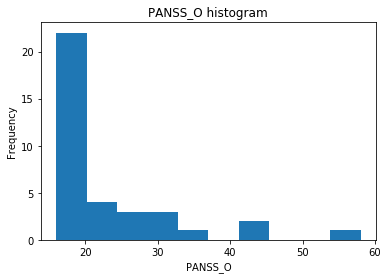

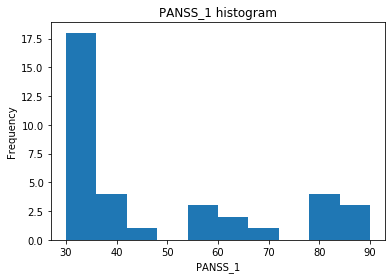

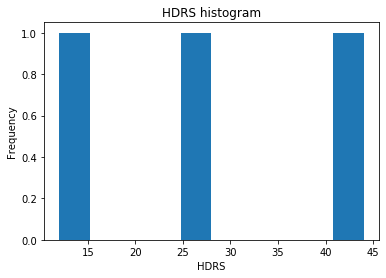

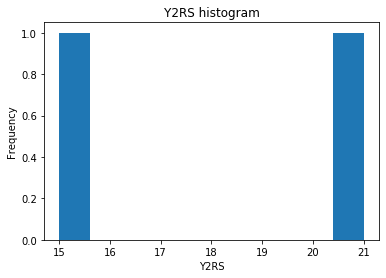

In [223]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_O', 'PANSS_1', 'HDRS', 'Y2RS']:
    animals.plot(y=col, kind='hist', legend=False)
    plt.xlabel(col)
    plt.title(f'{col} histogram');

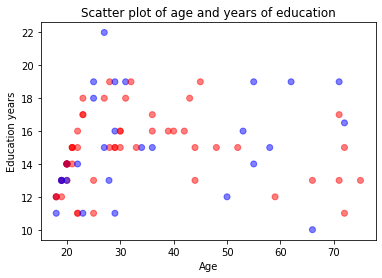

In [225]:
plt.scatter(animals['age'], animals['education'], 
            c=['red' if x == 1.0 else 'blue' for x in animals['sex']], alpha=0.5)
plt.ylabel('Education years')
plt.xlabel('Age')
plt.title('Scatter plot of age and years of education');

**let us see how categorical data is distributed**

In [226]:
animals['sex'].value_counts()

1.0    52
2.0    30
Name: sex, dtype: int64

In [227]:
animals['diagnosis'].value_counts()

0,00    62
1,00    10
3,00     5
2,00     5
Name: diagnosis, dtype: int64

**let us chect the normality**

In [230]:
animals[['age', 'education', 'TD', 'PANSS_O', 'PANSS_1']].apply(lambda l: stats.normaltest(l, nan_policy='omit')[1])

age          0.001114
education    0.384489
TD           0.045804
PANSS_O      0.000001
PANSS_1      0.032625
dtype: float64

**ok, most of it is definetiley not normally distributed, and we have seen that**<br>
- age
- TD
- PANSS

oh, well, let us use non-parametric correlations, like Spermans

In [231]:
stats.spearmanr(animals['age'], animals['education'])

SpearmanrResult(correlation=0.32738495106797816, pvalue=0.0026795870683662885)

good thing they are not correlated!

### let us correlate the number of clusters calculated by different methods

In [74]:
animals.head(1)

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,correct_c_num
ID,,,,,,,,,,,,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028,13,13,7,11,7,8,9,10,19,22,11


**Age**

In [239]:
methods = ['c_cut_median', 'c_cut_mean', 'c_cut_p25', 'c_cut_mean_local', 'c_sharp_1.05', 'c_sharp_1.005', 'c_sharp_1.00001', 'c_sharp_0.95', 'c_sharp_0.8', 'c_sharp_0.5']

In [240]:
age_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(animals['age'], animals[method]))
    age_corr.loc[method] = [r, p, p<0.05]

age_corr = pd.DataFrame([list(age_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
age_corr.style.background_gradient(axis=0, cmap='Reds')

,r,p,sig
c_cut_median,-0.304715,0.00537798,True
c_cut_mean,-0.330574,0.00241906,True
c_cut_p25,-0.369191,0.00064187,True
c_cut_mean_local,-0.377888,0.000465038,True
c_sharp_1.05,-0.341903,0.00166737,True
c_sharp_1.005,-0.325857,0.00281307,True
c_sharp_1.00001,-0.321883,0.00318872,True
c_sharp_0.95,-0.327688,0.00265377,True
c_sharp_0.8,-0.324257,0.00295924,True
c_sharp_0.5,-0.352719,0.00115362,True


Ok, so all of the methods do correlate negatively with age.<br>
The strongest are: 
- cutting at the local mean (r $\approx$ -0.37, p $\approx$ 0.006)
- cutting at the 25th percentile (r $\approx$ -0.37, p $\approx$ 0.0005)
- sharp cahge at 0.5 (r $\approx$ -0.35, p $\approx$ 0.001)

There are other things we **do not** expect to be correlated with anything

In [241]:
stats.spearmanr(animals['age'], animals['oov_words']) 

SpearmanrResult(correlation=-0.19701354471850194, pvalue=0.07605042653448194)

In [243]:
stats.spearmanr(animals['age'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=0.1547759897567317, pvalue=0.16500857235338776)

**Education years**

In [247]:
ed_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(animals['education'], animals[method]))
    ed_corr.loc[method] = [r, p, p<0.05]

ed_corr = pd.DataFrame([list(ed_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
ed_corr.style.background_gradient(axis=0, cmap='Reds')

,r,p,sig
c_cut_median,0.101078,0.366224,False
c_cut_mean,0.0794544,0.477972,False
c_cut_p25,0.0314407,0.779166,False
c_cut_mean_local,0.134688,0.22765,False
c_sharp_1.05,-0.00524572,0.962694,False
c_sharp_1.005,0.0749425,0.503395,False
c_sharp_1.00001,0.0768489,0.492569,False
c_sharp_0.95,0.0997767,0.372461,False
c_sharp_0.8,0.16294,0.14357,False
c_sharp_0.5,0.161446,0.147327,False


None of the metrics correlate with education, which is expected, since the manual splits did not.

The other things we **do not** expect to be correlated with anything

In [81]:
stats.spearmanr(animals['education'], animals['oov_words']) 

SpearmanrResult(correlation=0.07153684847087048, pvalue=0.6366127635943083)

In [248]:
stats.spearmanr(animals['education'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=-0.02416998398062832, pvalue=0.8293463866225094)

**Gender**

In [249]:
gender = animals['sex']

gender should not correlate on the metrics, as it does not on the manual splits

In [250]:
g_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(gender, animals[method]))
    g_corr.loc[method] = [r, p, p<0.05]

g_corr = pd.DataFrame([list(g_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
g_corr.style.background_gradient(axis=0, cmap='Reds')

,r,p,sig
c_cut_median,-0.223706,0.0433493,True
c_cut_mean,-0.221509,0.0455026,True
c_cut_p25,-0.21568,0.0516489,False
c_cut_mean_local,-0.196818,0.0763481,False
c_sharp_1.05,-0.225301,0.0418395,True
c_sharp_1.005,-0.210999,0.0570628,False
c_sharp_1.00001,-0.198633,0.0736212,False
c_sharp_0.95,-0.159821,0.151498,False
c_sharp_0.8,-0.138796,0.213653,False
c_sharp_0.5,-0.178985,0.107635,False


BUT WHY? multiple testing, my friend...

The other things we **do not** expect to be correlated with anything

In [86]:
stats.spearmanr(personal['Gender'], animals['oov_words']) 

SpearmanrResult(correlation=0.27529827717249056, pvalue=0.0640632456085686)

In [87]:
stats.spearmanr(personal['Gender'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=0.20979660203964265, pvalue=0.1616990909554755)